
== ABPC area per subgroup (supervoxel_type=full-organs) ==
true_positive_aggregation      : mean=2.0937e-05  std=3.1790e-05  n=8
false_positive_aggregation     : mean=4.2391e-06  std=1.1890e-05  n=8
dice_aggregation               : mean=1.6720e-01  std=3.0472e-01  n=8
logit_difference_aggregation   : mean=1.9995e-05  std=3.1022e-05  n=8


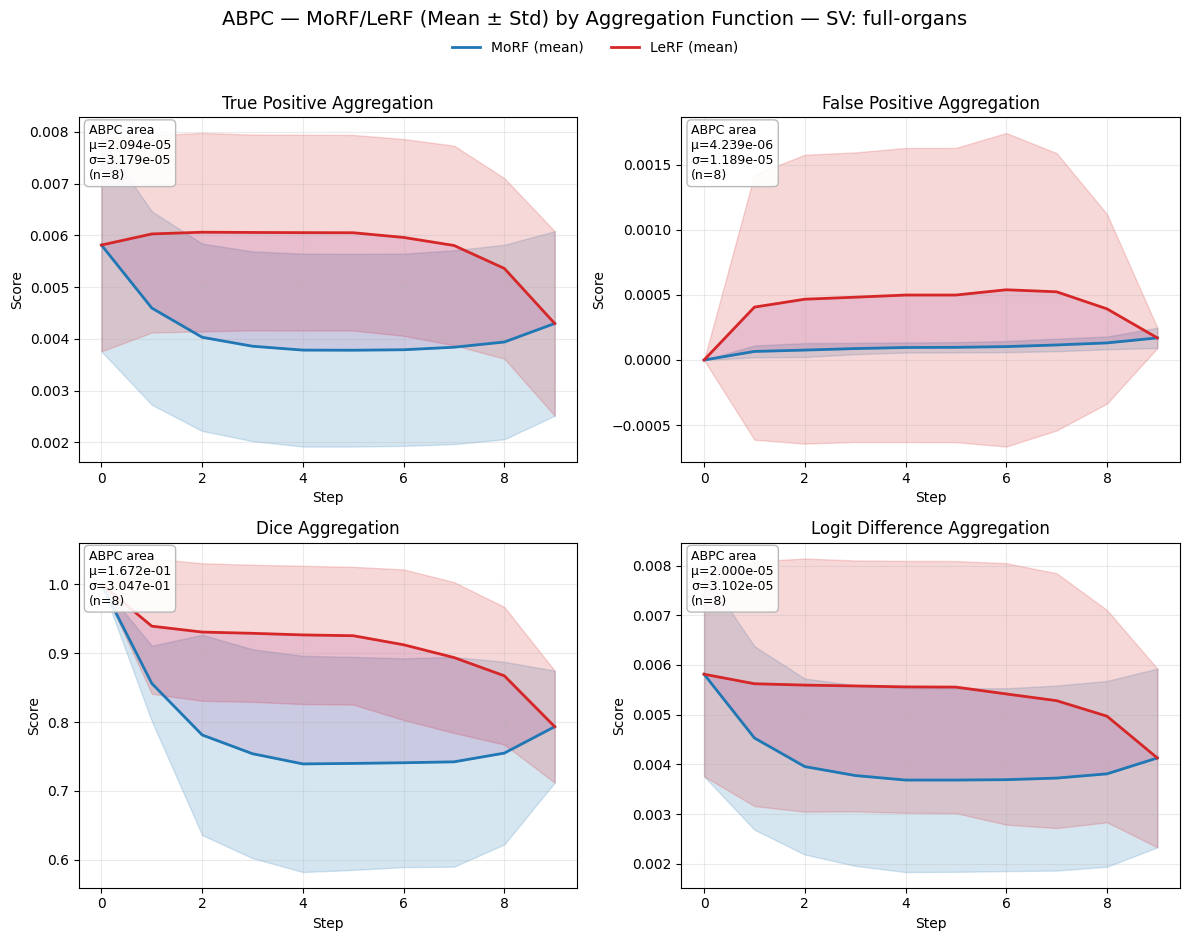

In [4]:
# matplotlib_abpc_dashboard_fast.py
# Fast dashboard for MoRF/LeRF + ABPC areas, optimized to minimize W&B API calls.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
from typing import Dict, List, Tuple

# ====== CONFIG ======
ENTITY = "giuliosichili"
PROJECT = "automi"
TOP_GROUP = "ABPC"

# Select ONE supervoxel type per run of this script
SELECTED_SV_TYPE = "full-organs"  # e.g., "full-organs" or "FCC-organs"

SUBGROUPS = [
    "true_positive_aggregation",
    "false_positive_aggregation",
    "dice_aggregation",
    "logit_difference_aggregation",
]
MORF_KEY = "MoRF"
LERF_KEY = "LeRF"
ABPC_KEY = "ABPC_area"
PAGE_SIZE = 256   # scan_history page size

# Colors
MORF_COLOR = "#1f77b4"   # blue
LERF_COLOR = "#d62728"   # red
GAP_COLOR  = "purple"
BAND_ALPHA = 0.18
GAP_ALPHA  = 0.12
# =====================

def fetch_runs_fast(api: wandb.Api, entity: str, project: str) -> List[wandb.apis.public.Run]:
    """
    Fetch only runs in the desired top group, with the chosen supervoxel type,
    and one of the expected aggregation subgroups.
    """
    path = f"{entity}/{project}"
    filt = {
        "config.group": {"$eq": TOP_GROUP},
        "config.supervoxel_type": {"$eq": SELECTED_SV_TYPE},
        "config.aggregation_function": {"$in": SUBGROUPS},
    }
    return list(api.runs(path, filters=filt))

def collect_group_data_fast(runs: List[wandb.apis.public.Run]) -> Dict[str, Dict]:
    """
    Returns:
      {
        subgroup: {
          'curves': np.ndarray (n, L, 2)  # (MoRF, LeRF) truncated to the common length L for that subgroup
          'abpc_values': List[float]
        }
      }
    """
    # Temporarily store variable-length sequences, then we'll align lengths
    curves_raw: Dict[str, List[np.ndarray]] = {sg: [] for sg in SUBGROUPS}
    abpc_vals: Dict[str, List[float]] = {sg: [] for sg in SUBGROUPS}
    lengths: Dict[str, List[int]] = {sg: [] for sg in SUBGROUPS}

    for r in runs:
        subgroup = (r.config or {}).get("aggregation_function")
        if subgroup not in curves_raw:
            continue

        morf_vals = {}
        lerf_vals = {}
        abpc_last = None

        # Early-stop scan: grab at most the first N common steps (unknown yet) and one ABPC value.
        # We don't know N upfront; we just collect all we see (up to PAGE_SIZE*pages implicitly).
        for row in r.scan_history(page_size=PAGE_SIZE):
            step = row.get("_step", row.get("step"))
            if step is None:
                continue

            if MORF_KEY in row and row[MORF_KEY] is not None:
                morf_vals[step] = float(row[MORF_KEY])
            if LERF_KEY in row and row[LERF_KEY] is not None:
                lerf_vals[step] = float(row[LERF_KEY])
            if ABPC_KEY in row and row[ABPC_KEY] is not None:
                abpc_last = float(row[ABPC_KEY])

        # Build the aligned series on all common steps (we'll truncate consistently later)
        common = sorted(set(morf_vals.keys()) & set(lerf_vals.keys()))
        if len(common) >= 2:  # need at least 2 points to make a curve/area meaningful
            morf_seq = np.array([morf_vals[s] for s in common], dtype=float)
            lerf_seq = np.array([lerf_vals[s] for s in common], dtype=float)
            seq = np.stack([morf_seq, lerf_seq], axis=1)  # (L_run, 2)
            curves_raw[subgroup].append(seq)
            lengths[subgroup].append(len(common))

        if abpc_last is not None:
            abpc_vals[subgroup].append(abpc_last)

    # Now, for each subgroup, choose a common length L and truncate all sequences to that L
    grouped: Dict[str, Dict] = {sg: {"curves": np.empty((0, 2, 2)), "abpc_values": abpc_vals[sg]} for sg in SUBGROUPS}
    for sg in SUBGROUPS:
        if not curves_raw[sg]:
            grouped[sg]["curves"] = np.empty((0, 2, 2), dtype=float)
            continue
        # Strategy: use the minimum length across runs in this subgroup (robust if a few runs are shorter)
        L = min(lengths[sg])
        truncated = [seq[:L] for seq in curves_raw[sg]]  # each is (L, 2)
        grouped[sg]["curves"] = np.stack(truncated, axis=0)  # (n, L, 2)

    return grouped

def summarize_curves(curves: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if curves.size == 0:
        return (np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0))
    morf = curves[:, :, 0]  # (n, L)
    lerf = curves[:, :, 1]  # (n, L)
    morf_mean = morf.mean(axis=0)
    lerf_mean = lerf.mean(axis=0)
    morf_std  = morf.std(axis=0, ddof=1) if morf.shape[0] > 1 else np.zeros_like(morf_mean)
    lerf_std  = lerf.std(axis=0, ddof=1) if lerf.shape[0] > 1 else np.zeros_like(lerf_mean)
    return morf_mean, morf_std, lerf_mean, lerf_std


def main():
    api = wandb.Api()
    runs = fetch_runs_fast(api, ENTITY, PROJECT)

    grouped = collect_group_data_fast(runs)

    # Console summary
    print(f"\n== ABPC area per subgroup (supervoxel_type={SELECTED_SV_TYPE}) ==")
    for sg in SUBGROUPS:
        vals = grouped[sg]["abpc_values"]
        if not vals:
            print(f"{sg:30s} : n=0")
        elif len(vals) == 1:
            print(f"{sg:30s} : mean={vals[0]:.4e} (n=1)")
        else:
            print(f"{sg:30s} : mean={np.mean(vals):.4e}  std={np.std(vals, ddof=1):.4e}  n={len(vals)}")

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=False, sharey=False)  # independent X and Y (L can differ)
    axes = axes.ravel()

    titles = {
        "true_positive_aggregation": "True Positive Aggregation",
        "false_positive_aggregation": "False Positive Aggregation",
        "dice_aggregation": "Dice Aggregation",
        "logit_difference_aggregation": "Logit Difference Aggregation",
    }

    for ax, sg in zip(axes, SUBGROUPS):
        curves = grouped[sg]["curves"]  # (n, L, 2)
        if curves.size == 0:
            ax.set_title(titles.get(sg, sg) + " (no data)")
            ax.grid(True, alpha=0.25)
            continue

        L = curves.shape[1]
        steps = np.arange(L)
        morf_mean, morf_std, lerf_mean, lerf_std = summarize_curves(curves)

        # std bands (colored)
        ax.fill_between(steps, morf_mean - morf_std, morf_mean + morf_std, color=MORF_COLOR, alpha=BAND_ALPHA)
        ax.fill_between(steps, lerf_mean - lerf_std, lerf_mean + lerf_std, color=LERF_COLOR, alpha=BAND_ALPHA)

        # mean lines (colored)
        ax.plot(steps, morf_mean, linewidth=2.0, color=MORF_COLOR, label="MoRF (mean)")
        ax.plot(steps, lerf_mean, linewidth=2.0, color=LERF_COLOR, label="LeRF (mean)")

        # purple gap
        gap_low  = np.minimum(morf_mean, lerf_mean)
        gap_high = np.maximum(morf_mean, lerf_mean)
        ax.fill_between(steps, gap_low, gap_high, color=GAP_COLOR, alpha=GAP_ALPHA)

        # ABPC stats box
        vals = grouped[sg]["abpc_values"]
        if vals:
            mean_abpc = np.mean(vals)
            std_abpc  = np.std(vals, ddof=1) if len(vals) > 1 else 0.0
            ax.text(0.02, 0.98, f"ABPC area\nμ={mean_abpc:.3e}\nσ={std_abpc:.3e}\n(n={len(vals)})",
                    transform=ax.transAxes, ha="left", va="top",
                    bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="0.7", alpha=0.9),
                    fontsize=9)

        ax.set_title(titles.get(sg, sg))
        ax.grid(True, alpha=0.25)
        ax.set_xlabel("Step")
        ax.set_ylabel("Score")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.02))
    fig.suptitle(f"ABPC — MoRF/LeRF (Mean ± Std) by Aggregation Function — SV: {SELECTED_SV_TYPE}", y=1.04, fontsize=14)
    fig.tight_layout()

    # Save with sv type in the filename
    safe_sv = SELECTED_SV_TYPE.replace(" ", "_")
    fig.savefig(f"abpc_dashboard_{safe_sv}.png", dpi=300, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    main()


## Save some observations about starting and ending points!

* the two curves start and end in the same point (all on and all off respectively)
* FP aggr. starts on 0, as there can't be spurious predictions for the original input with respect to itself
* Dice Aggregation starts on 1, because the baseline volume produces perfect overlapping with itself.
* TP and Logit Difference start on the same point, here 0.0059 approximately. This is because for the unperturbed volume, all the logits are in the baseline segmentation mask, so their sum is equal to the sum returned by True Positive mask.

these observation are maybe of limited interest, but they strengthen the reliability of these new defined metrics as the behavior is the one expected

## Other observations
* TP plot is very regular, in the sense that LeRF and MoRF curves are mostly simmetric around a point between them. This suggests that this notion of importance, given by preservation of predicted regions, is the most natural from a perspective that considers additivity of the parts (organs in this case) important, and also imply little feature interactions since attribution order is well respected in these plots.
* FP range, which is scaled equally to TP and Logit Difference and it's a logit sum like them, so it's comparable as unit, is very low compared to them. This shows limited spurious lymph nodes predictions, at least not close to baseline segmentation mask mass.
* Dice and LogDiff show a similar shape, and it's expected since the second is a continuous version of the first. We notice a decreasing monotonic behavior in LeRF curve, while the MoRF shows a decreasing and then increasing plot in the least important organs.



== ABPC area per subgroup (supervoxel_type=FCC-organs) ==
true_positive_aggregation      : n=0
false_positive_aggregation     : n=0
dice_aggregation               : mean=7.6441e+01  std=4.6952e+01  n=8
logit_difference_aggregation   : mean=7.6874e-01  std=5.1712e-01  n=8


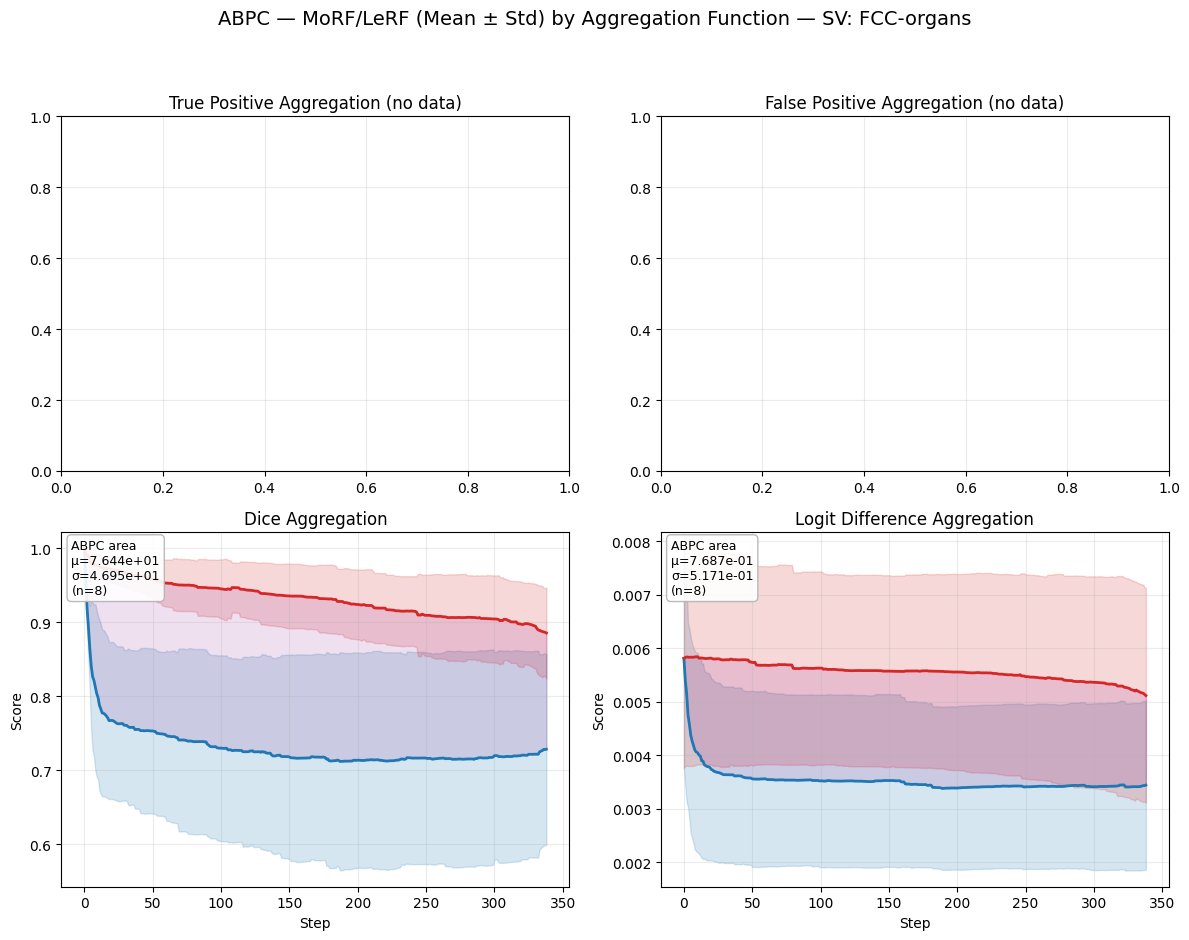

In [3]:
# matplotlib_abpc_dashboard_fast.py
# Fast dashboard for MoRF/LeRF + ABPC areas, optimized to minimize W&B API calls.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
from typing import Dict, List, Tuple

# ====== CONFIG ======
ENTITY = "giuliosichili"
PROJECT = "automi"
TOP_GROUP = "ABPC"

# Select ONE supervoxel type per run of this script
SELECTED_SV_TYPE = "FCC-organs"  # e.g., "full-organs" or "FCC-organs"

SUBGROUPS = [
    "true_positive_aggregation",
    "false_positive_aggregation",
    "dice_aggregation",
    "logit_difference_aggregation",
]
MORF_KEY = "MoRF"
LERF_KEY = "LeRF"
ABPC_KEY = "ABPC_area"
PAGE_SIZE = 256   # scan_history page size

# Colors
MORF_COLOR = "#1f77b4"   # blue
LERF_COLOR = "#d62728"   # red
GAP_COLOR  = "purple"
BAND_ALPHA = 0.18
GAP_ALPHA  = 0.12
# =====================

def fetch_runs_fast(api: wandb.Api, entity: str, project: str) -> List[wandb.apis.public.Run]:
    """
    Fetch only runs in the desired top group, with the chosen supervoxel type,
    and one of the expected aggregation subgroups.
    """
    path = f"{entity}/{project}"
    filt = {
        "config.group": {"$eq": TOP_GROUP},
        "config.supervoxel_type": {"$eq": SELECTED_SV_TYPE},
        "config.aggregation_function": {"$in": SUBGROUPS},
    }
    return list(api.runs(path, filters=filt))

def collect_group_data_fast(runs: List[wandb.apis.public.Run]) -> Dict[str, Dict]:
    """
    Returns:
      {
        subgroup: {
          'curves': np.ndarray (n, L, 2)  # (MoRF, LeRF) truncated to the common length L for that subgroup
          'abpc_values': List[float]
        }
      }
    """
    # Temporarily store variable-length sequences, then we'll align lengths
    curves_raw: Dict[str, List[np.ndarray]] = {sg: [] for sg in SUBGROUPS}
    abpc_vals: Dict[str, List[float]] = {sg: [] for sg in SUBGROUPS}
    lengths: Dict[str, List[int]] = {sg: [] for sg in SUBGROUPS}

    for r in runs:
        subgroup = (r.config or {}).get("aggregation_function")
        if subgroup not in curves_raw:
            continue

        morf_vals = {}
        lerf_vals = {}
        abpc_last = None

        # Early-stop scan: grab at most the first N common steps (unknown yet) and one ABPC value.
        # We don't know N upfront; we just collect all we see (up to PAGE_SIZE*pages implicitly).
        for row in r.scan_history(page_size=PAGE_SIZE):
            step = row.get("_step", row.get("step"))
            if step is None:
                continue

            if MORF_KEY in row and row[MORF_KEY] is not None:
                morf_vals[step] = float(row[MORF_KEY])
            if LERF_KEY in row and row[LERF_KEY] is not None:
                lerf_vals[step] = float(row[LERF_KEY])
            if ABPC_KEY in row and row[ABPC_KEY] is not None:
                abpc_last = float(row[ABPC_KEY])

        # Build the aligned series on all common steps (we'll truncate consistently later)
        common = sorted(set(morf_vals.keys()) & set(lerf_vals.keys()))
        if len(common) >= 2:  # need at least 2 points to make a curve/area meaningful
            morf_seq = np.array([morf_vals[s] for s in common], dtype=float)
            lerf_seq = np.array([lerf_vals[s] for s in common], dtype=float)
            seq = np.stack([morf_seq, lerf_seq], axis=1)  # (L_run, 2)
            curves_raw[subgroup].append(seq)
            lengths[subgroup].append(len(common))

        if abpc_last is not None:
            abpc_vals[subgroup].append(abpc_last)

    # Now, for each subgroup, choose a common length L and truncate all sequences to that L
    grouped: Dict[str, Dict] = {sg: {"curves": np.empty((0, 2, 2)), "abpc_values": abpc_vals[sg]} for sg in SUBGROUPS}
    for sg in SUBGROUPS:
        if not curves_raw[sg]:
            grouped[sg]["curves"] = np.empty((0, 2, 2), dtype=float)
            continue
        # Strategy: use the minimum length across runs in this subgroup (robust if a few runs are shorter)
        L = min(lengths[sg])
        truncated = [seq[:L] for seq in curves_raw[sg]]  # each is (L, 2)
        grouped[sg]["curves"] = np.stack(truncated, axis=0)  # (n, L, 2)

    return grouped

def summarize_curves(curves: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if curves.size == 0:
        return (np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0))
    morf = curves[:, :, 0]  # (n, L)
    lerf = curves[:, :, 1]  # (n, L)
    morf_mean = morf.mean(axis=0)
    lerf_mean = lerf.mean(axis=0)
    morf_std  = morf.std(axis=0, ddof=1) if morf.shape[0] > 1 else np.zeros_like(morf_mean)
    lerf_std  = lerf.std(axis=0, ddof=1) if lerf.shape[0] > 1 else np.zeros_like(lerf_mean)
    return morf_mean, morf_std, lerf_mean, lerf_std


def main():
    api = wandb.Api()
    runs = fetch_runs_fast(api, ENTITY, PROJECT)

    grouped = collect_group_data_fast(runs)

    # Console summary
    print(f"\n== ABPC area per subgroup (supervoxel_type={SELECTED_SV_TYPE}) ==")
    for sg in SUBGROUPS:
        vals = grouped[sg]["abpc_values"]
        if not vals:
            print(f"{sg:30s} : n=0")
        elif len(vals) == 1:
            print(f"{sg:30s} : mean={vals[0]:.4e} (n=1)")
        else:
            print(f"{sg:30s} : mean={np.mean(vals):.4e}  std={np.std(vals, ddof=1):.4e}  n={len(vals)}")

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=False, sharey=False)  # independent X and Y (L can differ)
    axes = axes.ravel()

    titles = {
        "true_positive_aggregation": "True Positive Aggregation",
        "false_positive_aggregation": "False Positive Aggregation",
        "dice_aggregation": "Dice Aggregation",
        "logit_difference_aggregation": "Logit Difference Aggregation",
    }

    for ax, sg in zip(axes, SUBGROUPS):
        curves = grouped[sg]["curves"]  # (n, L, 2)
        if curves.size == 0:
            ax.set_title(titles.get(sg, sg) + " (no data)")
            ax.grid(True, alpha=0.25)
            continue

        L = curves.shape[1]
        steps = np.arange(L)
        morf_mean, morf_std, lerf_mean, lerf_std = summarize_curves(curves)

        # std bands (colored)
        ax.fill_between(steps, morf_mean - morf_std, morf_mean + morf_std, color=MORF_COLOR, alpha=BAND_ALPHA)
        ax.fill_between(steps, lerf_mean - lerf_std, lerf_mean + lerf_std, color=LERF_COLOR, alpha=BAND_ALPHA)

        # mean lines (colored)
        ax.plot(steps, morf_mean, linewidth=2.0, color=MORF_COLOR, label="MoRF (mean)")
        ax.plot(steps, lerf_mean, linewidth=2.0, color=LERF_COLOR, label="LeRF (mean)")

        # purple gap
        gap_low  = np.minimum(morf_mean, lerf_mean)
        gap_high = np.maximum(morf_mean, lerf_mean)
        ax.fill_between(steps, gap_low, gap_high, color=GAP_COLOR, alpha=GAP_ALPHA)

        # ABPC stats box
        vals = grouped[sg]["abpc_values"]
        if vals:
            mean_abpc = np.mean(vals)
            std_abpc  = np.std(vals, ddof=1) if len(vals) > 1 else 0.0
            ax.text(0.02, 0.98, f"ABPC area\nμ={mean_abpc:.3e}\nσ={std_abpc:.3e}\n(n={len(vals)})",
                    transform=ax.transAxes, ha="left", va="top",
                    bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="0.7", alpha=0.9),
                    fontsize=9)

        ax.set_title(titles.get(sg, sg))
        ax.grid(True, alpha=0.25)
        ax.set_xlabel("Step")
        ax.set_ylabel("Score")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.02))
    fig.suptitle(f"ABPC — MoRF/LeRF (Mean ± Std) by Aggregation Function — SV: {SELECTED_SV_TYPE}", y=1.04, fontsize=14)
    fig.tight_layout()

    # Save with sv type in the filename
    safe_sv = SELECTED_SV_TYPE.replace(" ", "_")
    fig.savefig(f"abpc_dashboard_{safe_sv}.png", dpi=300, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    main()



== ABPC area per subgroup (supervoxel_type=FCC-organs) ==
true_positive_aggregation      : n=0
false_positive_aggregation     : n=0
dice_aggregation               : mean=7.6441e+01  std=4.6952e+01  n=8
logit_difference_aggregation   : mean=7.6874e-01  std=5.1712e-01  n=8


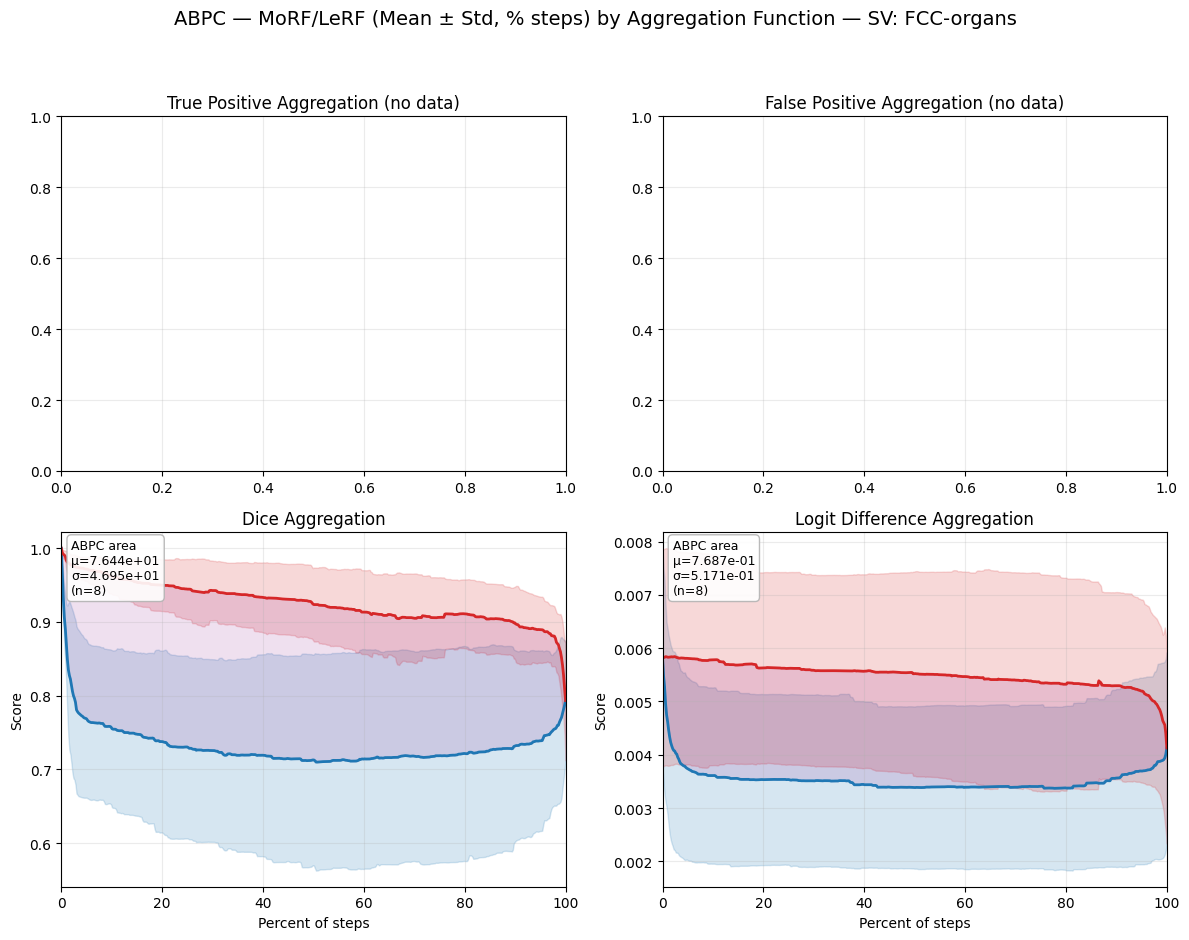

In [6]:
# matplotlib_abpc_dashboard_fast.py
# Fast dashboard for MoRF/LeRF + ABPC areas, with percentage-aligned curves (interpolated to L_max).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
from typing import Dict, List, Tuple

# ====== CONFIG ======
ENTITY = "giuliosichili"
PROJECT = "automi"
TOP_GROUP = "ABPC"

# Select ONE supervoxel type per run of this script
SELECTED_SV_TYPE = "FCC-organs"  # e.g., "full-organs" or "FCC-organs"

SUBGROUPS = [
    "true_positive_aggregation",
    "false_positive_aggregation",
    "dice_aggregation",
    "logit_difference_aggregation",
]
MORF_KEY = "MoRF"
LERF_KEY = "LeRF"
ABPC_KEY = "ABPC_area"
PAGE_SIZE = 256   # scan_history page size

# Colors
MORF_COLOR = "#1f77b4"   # blue
LERF_COLOR = "#d62728"   # red
GAP_COLOR  = "purple"
BAND_ALPHA = 0.18
GAP_ALPHA  = 0.12
# =====================

def fetch_runs_fast(api: wandb.Api, entity: str, project: str) -> List[wandb.apis.public.Run]:
    """
    Fetch only runs in the desired top group, with the chosen supervoxel type,
    and one of the expected aggregation subgroups.
    """
    path = f"{entity}/{project}"
    filt = {
        "config.group": {"$eq": TOP_GROUP},
        "config.supervoxel_type": {"$eq": SELECTED_SV_TYPE},
        "config.aggregation_function": {"$in": SUBGROUPS},
    }
    return list(api.runs(path, filters=filt))

def _resample_to_length(y: np.ndarray, L_target: int) -> np.ndarray:
    """
    Linearly interpolate a 1D array y (length L_run) onto L_target points over [0,1].
    Handles L_run == 1 by repeating the single value.
    """
    L_run = len(y)
    if L_run <= 0:
        return np.zeros(L_target, dtype=float)
    if L_run == 1:
        return np.full(L_target, float(y[0]), dtype=float)
    x_src = np.linspace(0.0, 1.0, L_run)
    x_tgt = np.linspace(0.0, 1.0, L_target)
    return np.interp(x_tgt, x_src, y)

def collect_group_data_fast(runs: List[wandb.apis.public.Run]) -> Dict[str, Dict]:
    """
    Returns:
      {
        subgroup: {
          'curves': np.ndarray (n, L_max, 2)  # (MoRF, LeRF) resampled to the subgroup's L_max
          'abpc_values': List[float]
        }
      }
    """
    # First pass: collect variable-length sequences per run
    curves_raw: Dict[str, List[np.ndarray]] = {sg: [] for sg in SUBGROUPS}
    abpc_vals: Dict[str, List[float]] = {sg: [] for sg in SUBGROUPS}
    lengths: Dict[str, List[int]] = {sg: [] for sg in SUBGROUPS}

    for r in runs:
        subgroup = (r.config or {}).get("aggregation_function")
        if subgroup not in curves_raw:
            continue

        morf_vals = {}
        lerf_vals = {}
        abpc_last = None

        for row in r.scan_history(page_size=PAGE_SIZE):
            step = row.get("_step", row.get("step"))
            if step is None:
                continue
            if MORF_KEY in row and row[MORF_KEY] is not None:
                morf_vals[step] = float(row[MORF_KEY])
            if LERF_KEY in row and row[LERF_KEY] is not None:
                lerf_vals[step] = float(row[LERF_KEY])
            if ABPC_KEY in row and row[ABPC_KEY] is not None:
                abpc_last = float(row[ABPC_KEY])

        # Build the aligned series on all common steps
        common = sorted(set(morf_vals.keys()) & set(lerf_vals.keys()))
        if len(common) >= 1:
            morf_seq = np.array([morf_vals[s] for s in common], dtype=float)
            lerf_seq = np.array([lerf_vals[s] for s in common], dtype=float)
            seq = np.stack([morf_seq, lerf_seq], axis=1)  # (L_run, 2)
            curves_raw[subgroup].append(seq)
            lengths[subgroup].append(len(common))

        if abpc_last is not None:
            abpc_vals[subgroup].append(abpc_last)

    # Second pass: for each subgroup, resample each run to L_max over percentage x ∈ [0,1]
    grouped: Dict[str, Dict] = {sg: {"curves": np.empty((0, 2, 2)), "abpc_values": abpc_vals[sg]} for sg in SUBGROUPS}
    for sg in SUBGROUPS:
        runs_seq = curves_raw[sg]
        if not runs_seq:
            grouped[sg]["curves"] = np.empty((0, 2, 2), dtype=float)
            continue
        L_max = max(lengths[sg])  # longest run defines the reference
        resampled = []
        for seq in runs_seq:
            morf_seq = seq[:, 0]
            lerf_seq = seq[:, 1]
            morf_rs = _resample_to_length(morf_seq, L_max)
            lerf_rs = _resample_to_length(lerf_seq, L_max)
            resampled.append(np.stack([morf_rs, lerf_rs], axis=1))  # (L_max, 2)
        grouped[sg]["curves"] = np.stack(resampled, axis=0)  # (n, L_max, 2)

    return grouped

def summarize_curves(curves: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    curves: (n, L, 2). Returns mean±std for MoRF/LeRF across runs at each of L percentage points.
    """
    if curves.size == 0:
        return (np.zeros(0), np.zeros(0), np.zeros(0), np.zeros(0))
    morf = curves[:, :, 0]  # (n, L)
    lerf = curves[:, :, 1]  # (n, L)
    morf_mean = morf.mean(axis=0)
    lerf_mean = lerf.mean(axis=0)
    morf_std  = morf.std(axis=0, ddof=1) if morf.shape[0] > 1 else np.zeros_like(morf_mean)
    lerf_std  = lerf.std(axis=0, ddof=1) if lerf.shape[0] > 1 else np.zeros_like(lerf_mean)
    return morf_mean, morf_std, lerf_mean, lerf_std

def main():
    api = wandb.Api()
    runs = fetch_runs_fast(api, ENTITY, PROJECT)
    grouped = collect_group_data_fast(runs)

    # Console summary
    print(f"\n== ABPC area per subgroup (supervoxel_type={SELECTED_SV_TYPE}) ==")
    for sg in SUBGROUPS:
        vals = grouped[sg]["abpc_values"]
        if not vals:
            print(f"{sg:30s} : n=0")
        elif len(vals) == 1:
            print(f"{sg:30s} : mean={vals[0]:.4e} (n=1)")
        else:
            print(f"{sg:30s} : mean={np.mean(vals):.4e}  std={np.std(vals, ddof=1):.4e}  n={len(vals)}")

    # Plot (independent X and Y; L can differ across subgroups)
    fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=False, sharey=False)
    axes = axes.ravel()

    titles = {
        "true_positive_aggregation": "True Positive Aggregation",
        "false_positive_aggregation": "False Positive Aggregation",
        "dice_aggregation": "Dice Aggregation",
        "logit_difference_aggregation": "Logit Difference Aggregation",
    }

    for ax, sg in zip(axes, SUBGROUPS):
        curves = grouped[sg]["curves"]  # (n, L_max, 2)
        if curves.size == 0:
            ax.set_title(titles.get(sg, sg) + " (no data)")
            ax.grid(True, alpha=0.25)
            continue

        L = curves.shape[1]
        x_pct = np.linspace(0, 100, L)  # percentage of steps [0..100]
        morf_mean, morf_std, lerf_mean, lerf_std = summarize_curves(curves)

        # std bands (colored)
        ax.fill_between(x_pct, morf_mean - morf_std, morf_mean + morf_std, color=MORF_COLOR, alpha=BAND_ALPHA)
        ax.fill_between(x_pct, lerf_mean - lerf_std, lerf_mean + lerf_std, color=LERF_COLOR, alpha=BAND_ALPHA)

        # mean lines (colored)
        ax.plot(x_pct, morf_mean, linewidth=2.0, color=MORF_COLOR, label="MoRF (mean)")
        ax.plot(x_pct, lerf_mean, linewidth=2.0, color=LERF_COLOR, label="LeRF (mean)")

        # purple gap
        gap_low  = np.minimum(morf_mean, lerf_mean)
        gap_high = np.maximum(morf_mean, lerf_mean)
        ax.fill_between(x_pct, gap_low, gap_high, color=GAP_COLOR, alpha=GAP_ALPHA)

        # ABPC stats box
        vals = grouped[sg]["abpc_values"]
        if vals:
            mean_abpc = np.mean(vals)
            std_abpc  = np.std(vals, ddof=1) if len(vals) > 1 else 0.0
            ax.text(0.02, 0.98, f"ABPC area\nμ={mean_abpc:.3e}\nσ={std_abpc:.3e}\n(n={len(vals)})",
                    transform=ax.transAxes, ha="left", va="top",
                    bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="0.7", alpha=0.9),
                    fontsize=9)

        ax.set_title(titles.get(sg, sg))
        ax.grid(True, alpha=0.25)
        ax.set_xlabel("Percent of steps")
        ax.set_ylabel("Score")
        ax.set_xlim(0, 100)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.02))
    fig.suptitle(f"ABPC — MoRF/LeRF (Mean ± Std, % steps) by Aggregation Function — SV: {SELECTED_SV_TYPE}",
                 y=1.04, fontsize=14)
    fig.tight_layout()

    # Save with sv type in the filename
    safe_sv = SELECTED_SV_TYPE.replace(" ", "_")
    fig.savefig(f"abpc_dashboard_pct_{safe_sv}.png", dpi=300, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    main()
